<a href="https://colab.research.google.com/github/a-salmeron/copy-NBA-prediction-/blob/main/project_128B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit

# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

# set seed for reproducibility
seed=99

In [2]:
# database tables
game_info = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/game_info.csv', index_col=0)
team_stats = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/team_stats.csv', index_col=0)

# four factor data (10, 20, 30, 40, 50 game averages)
team_factor_10 = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/team_factor_10.csv', index_col=0)
team_factor_20 = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/team_factor_20.csv', index_col=0)
team_factor_30 = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/team_factor_30.csv', index_col=0)
team_factor_40 = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/team_factor_40.csv', index_col=0)
team_factor_50 = pd.read_csv('https://github.com/a-salmeron/copy-NBA-prediction-/raw/refs/heads/main/data/team_factor_50.csv', index_col=0)


In [3]:
# all boxscore data (10, 20, 30 game averages)
# team_full_10 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_10.csv', index_col=0)
# team_full_20 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_20.csv', index_col=0)
# team_full_30 = pd.read_csv('https://raw.githubusercontent.com/luke-lite/NBA-Prediction-Modeling/main/data/team_full_30.csv', index_col=0)

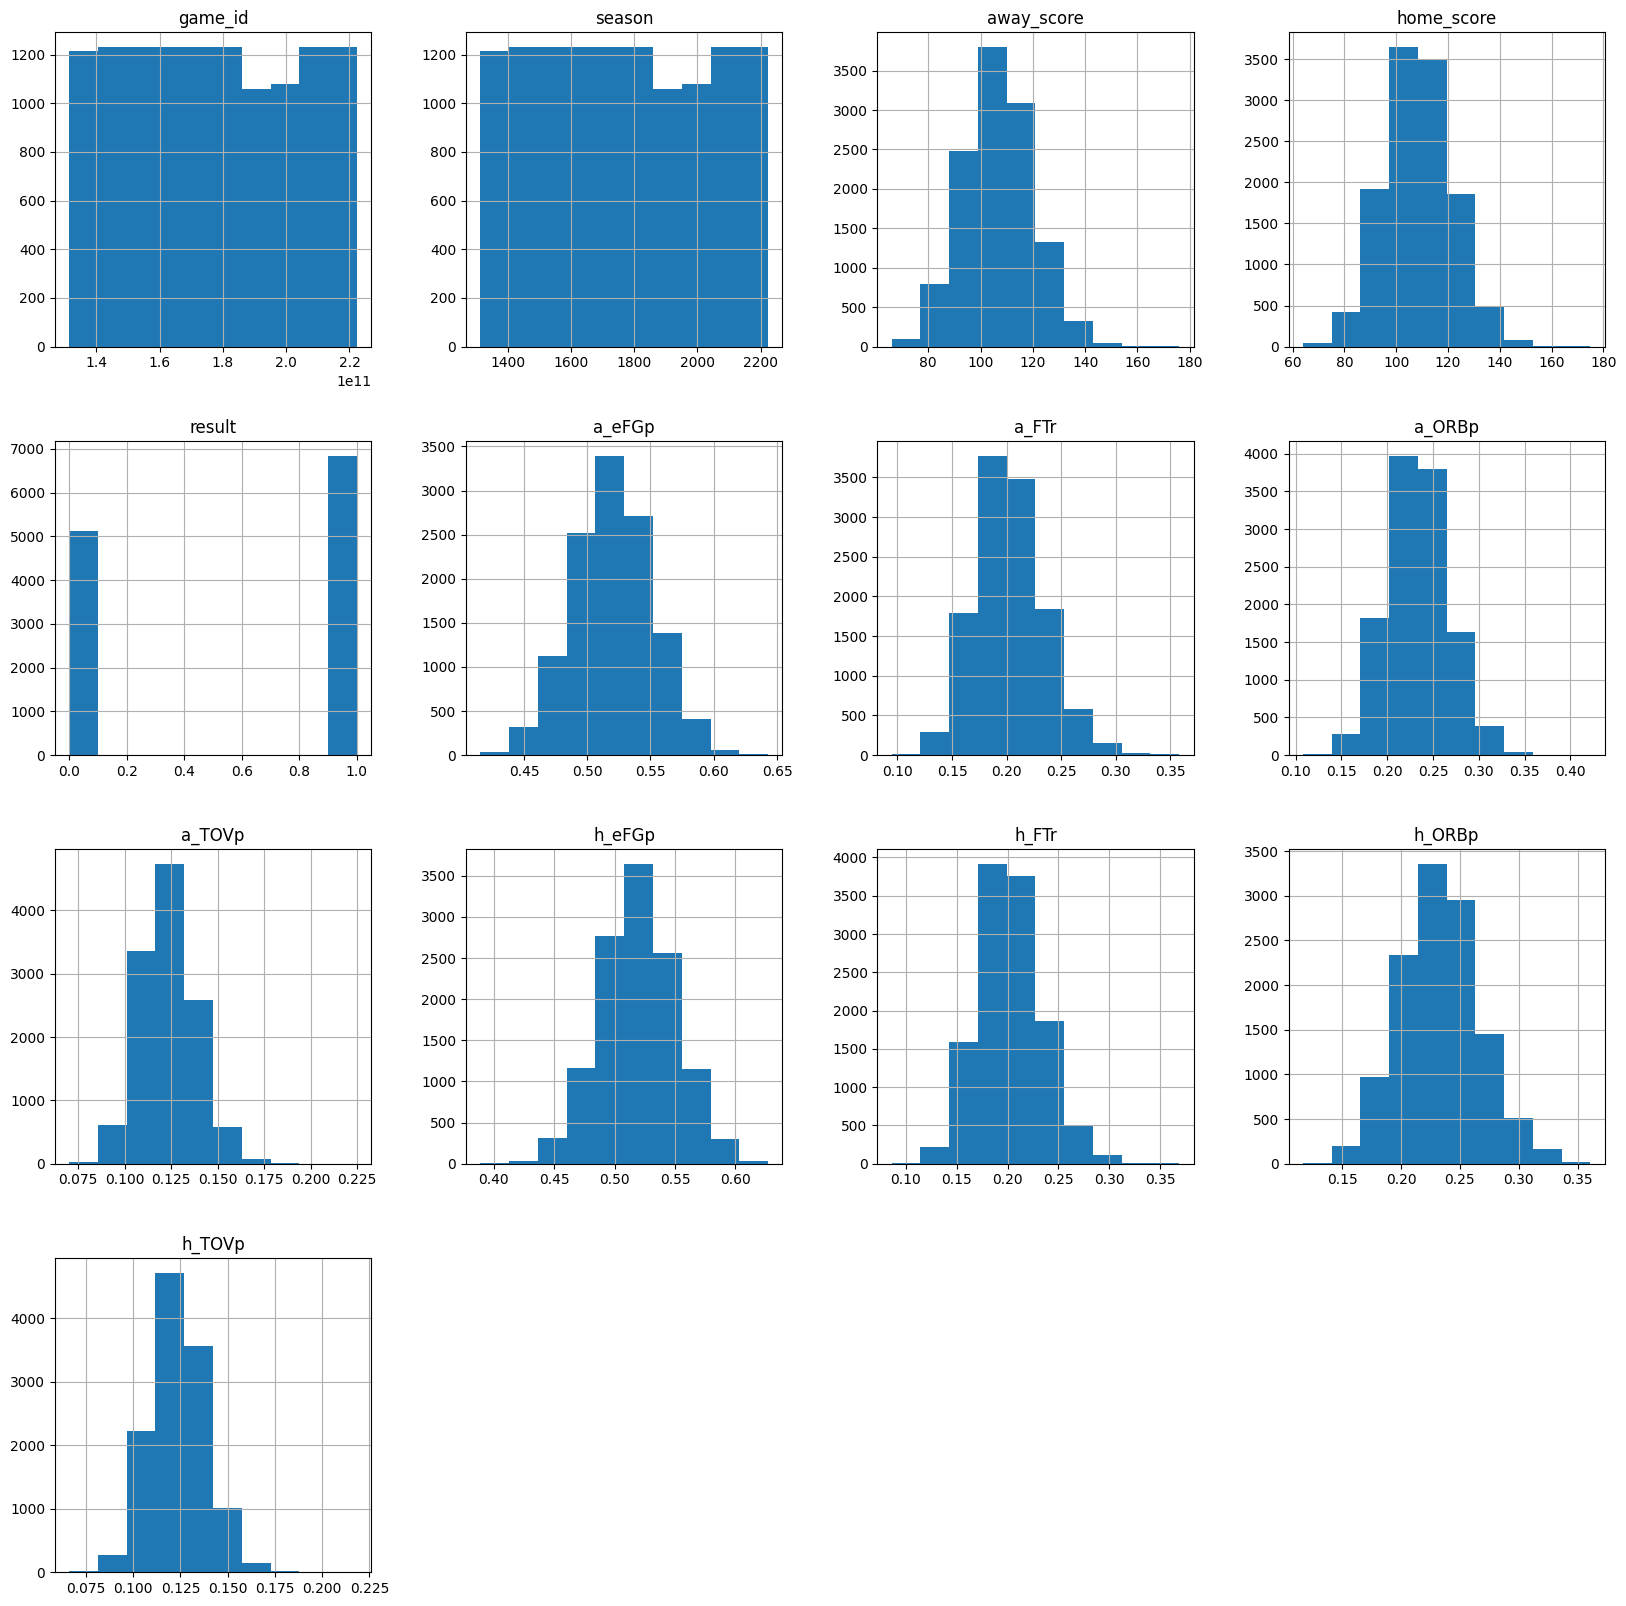

In [4]:
team_factor_10.dropna(inplace=True)
team_factor_10.reset_index(drop=True, inplace=True)
team_factor_10.hist(figsize=(20,20));

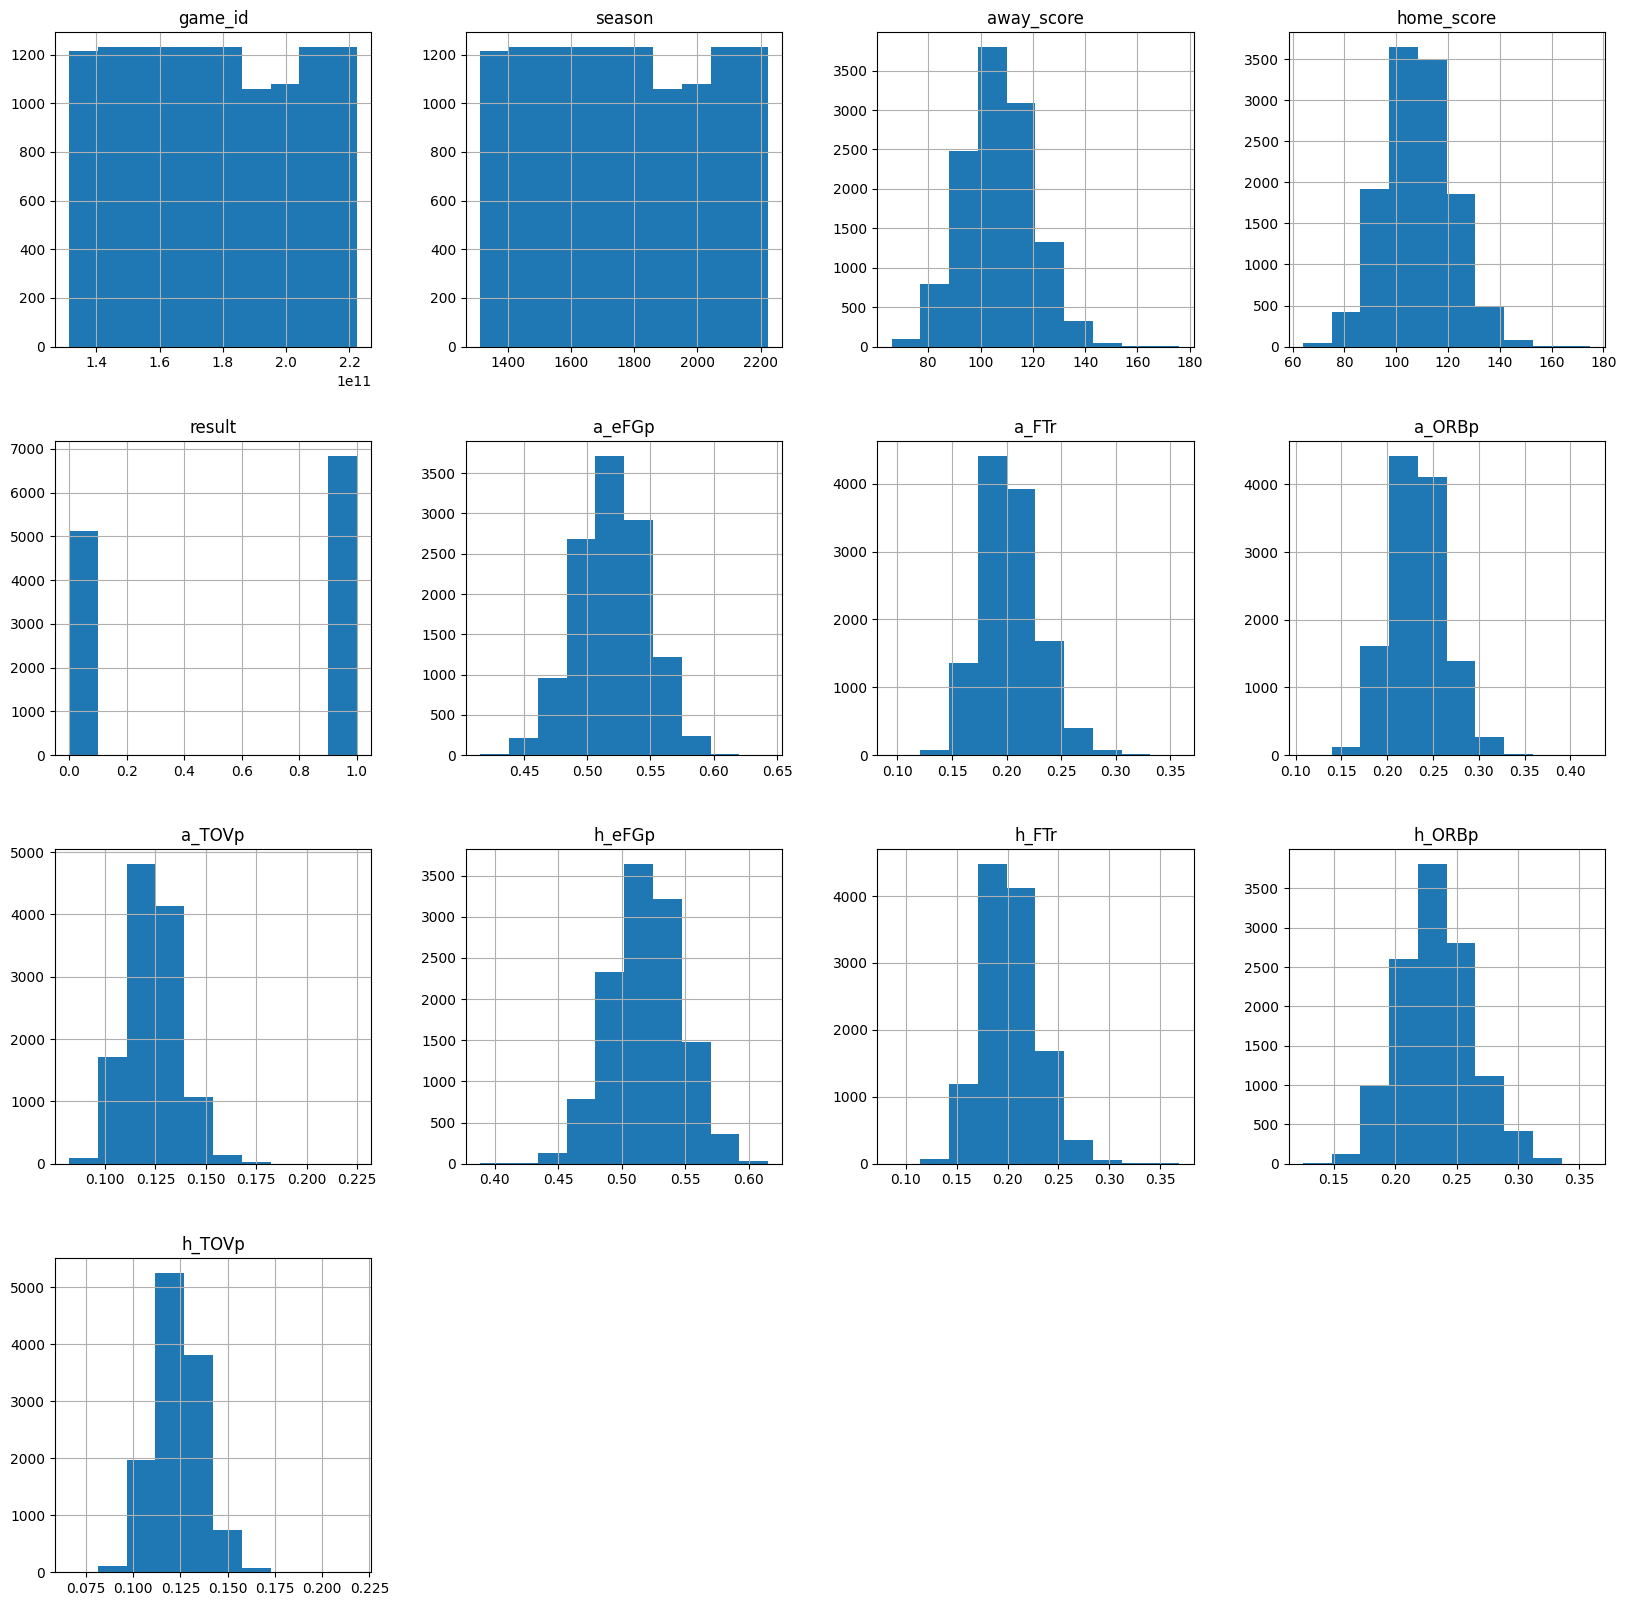

In [5]:
team_factor_20.dropna(inplace=True)
team_factor_20.reset_index(drop=True, inplace=True)
team_factor_20.hist(figsize=(20,20));

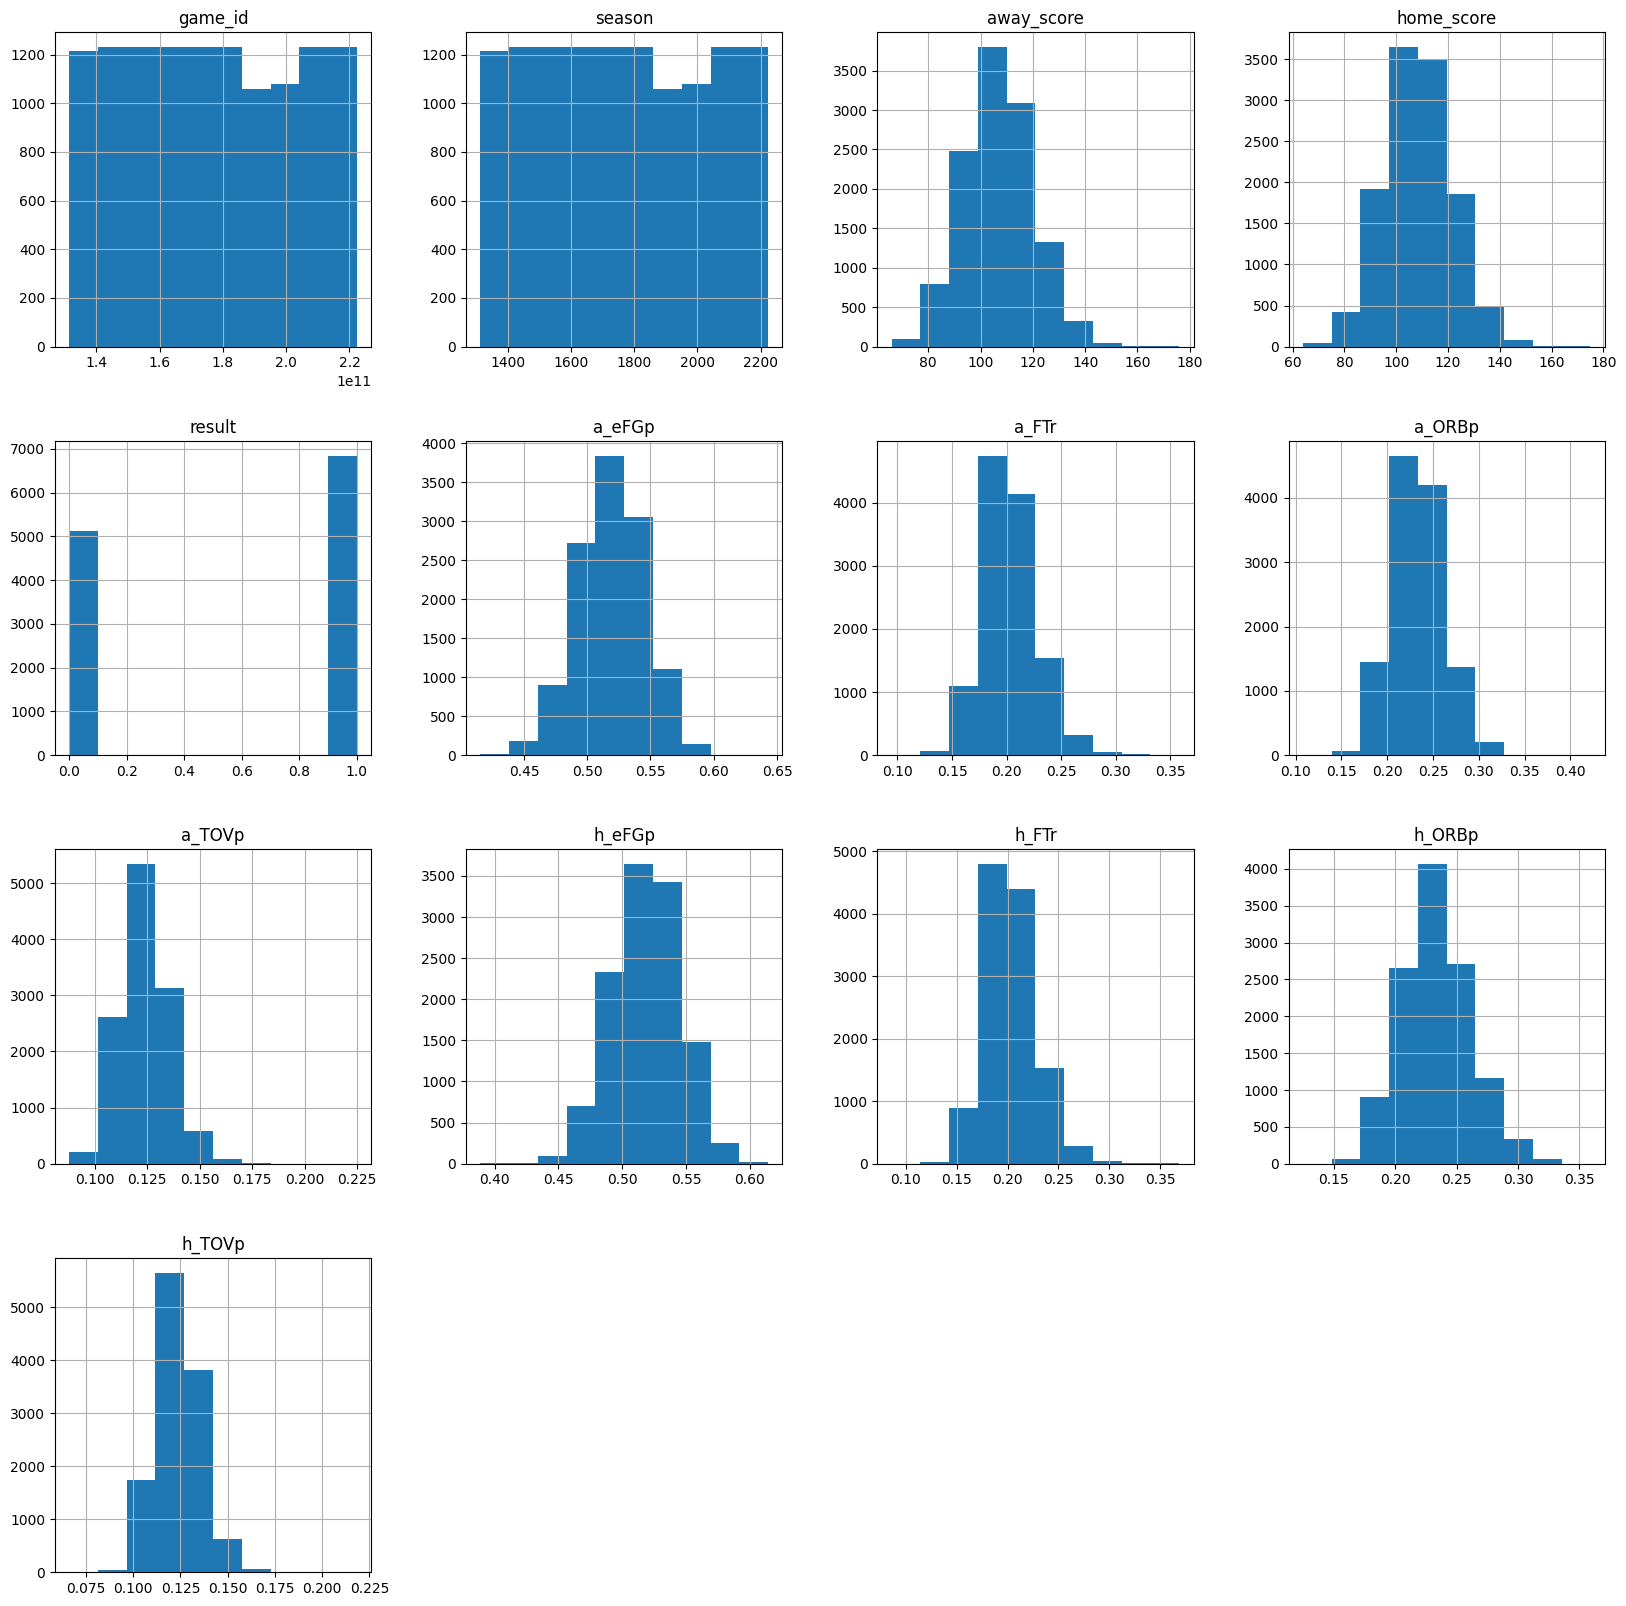

In [6]:
team_factor_30.dropna(inplace=True)
team_factor_30.reset_index(drop=True, inplace=True)
team_factor_30.hist(figsize=(20,20));

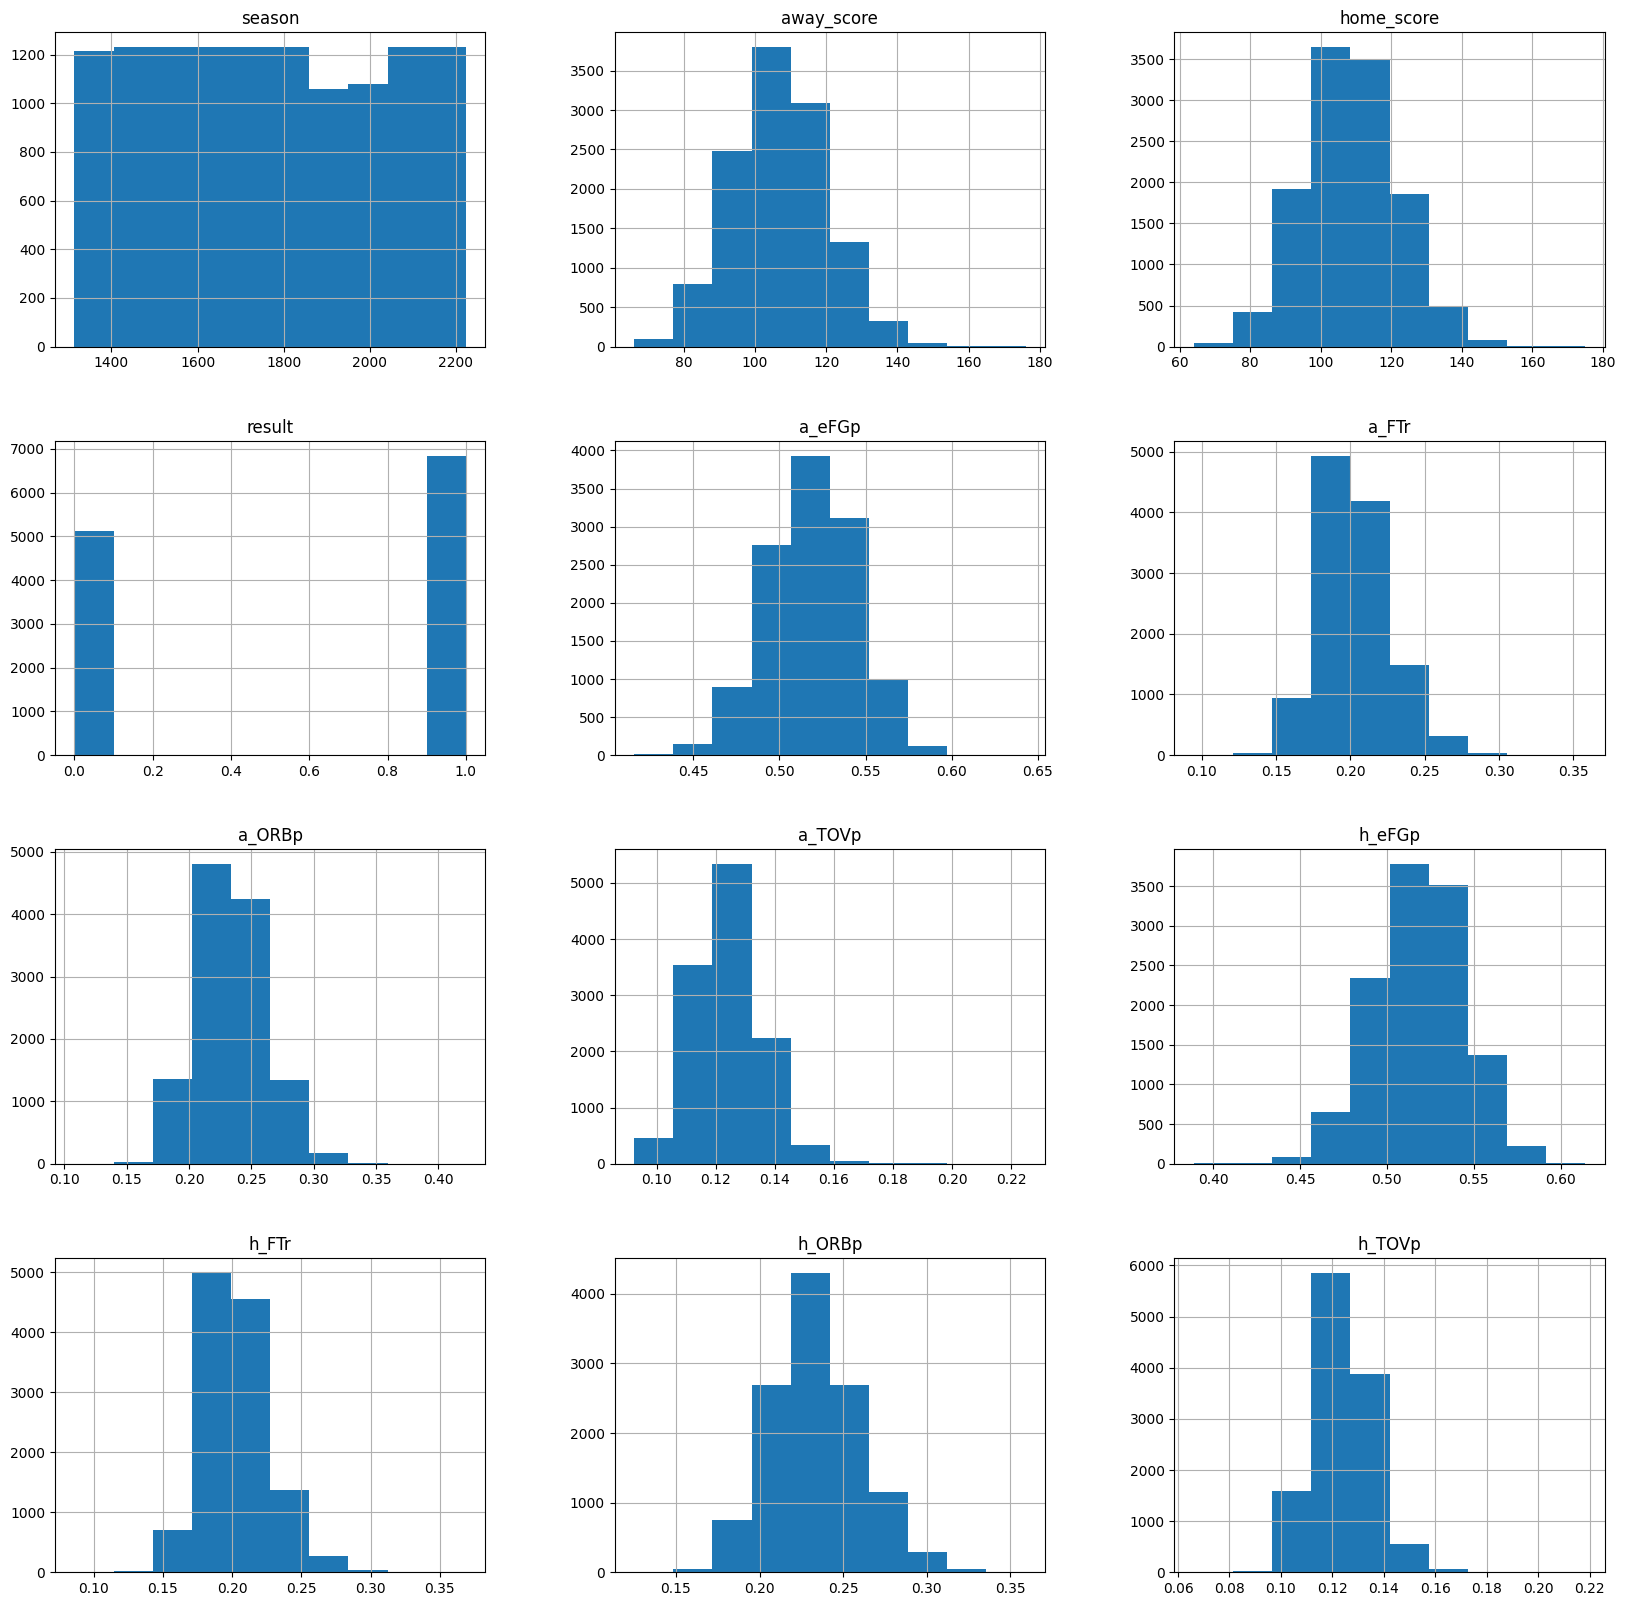

In [7]:
team_factor_40.dropna(inplace=True)
team_factor_40.reset_index(drop=True, inplace=True)
team_factor_40.hist(figsize=(20,20));

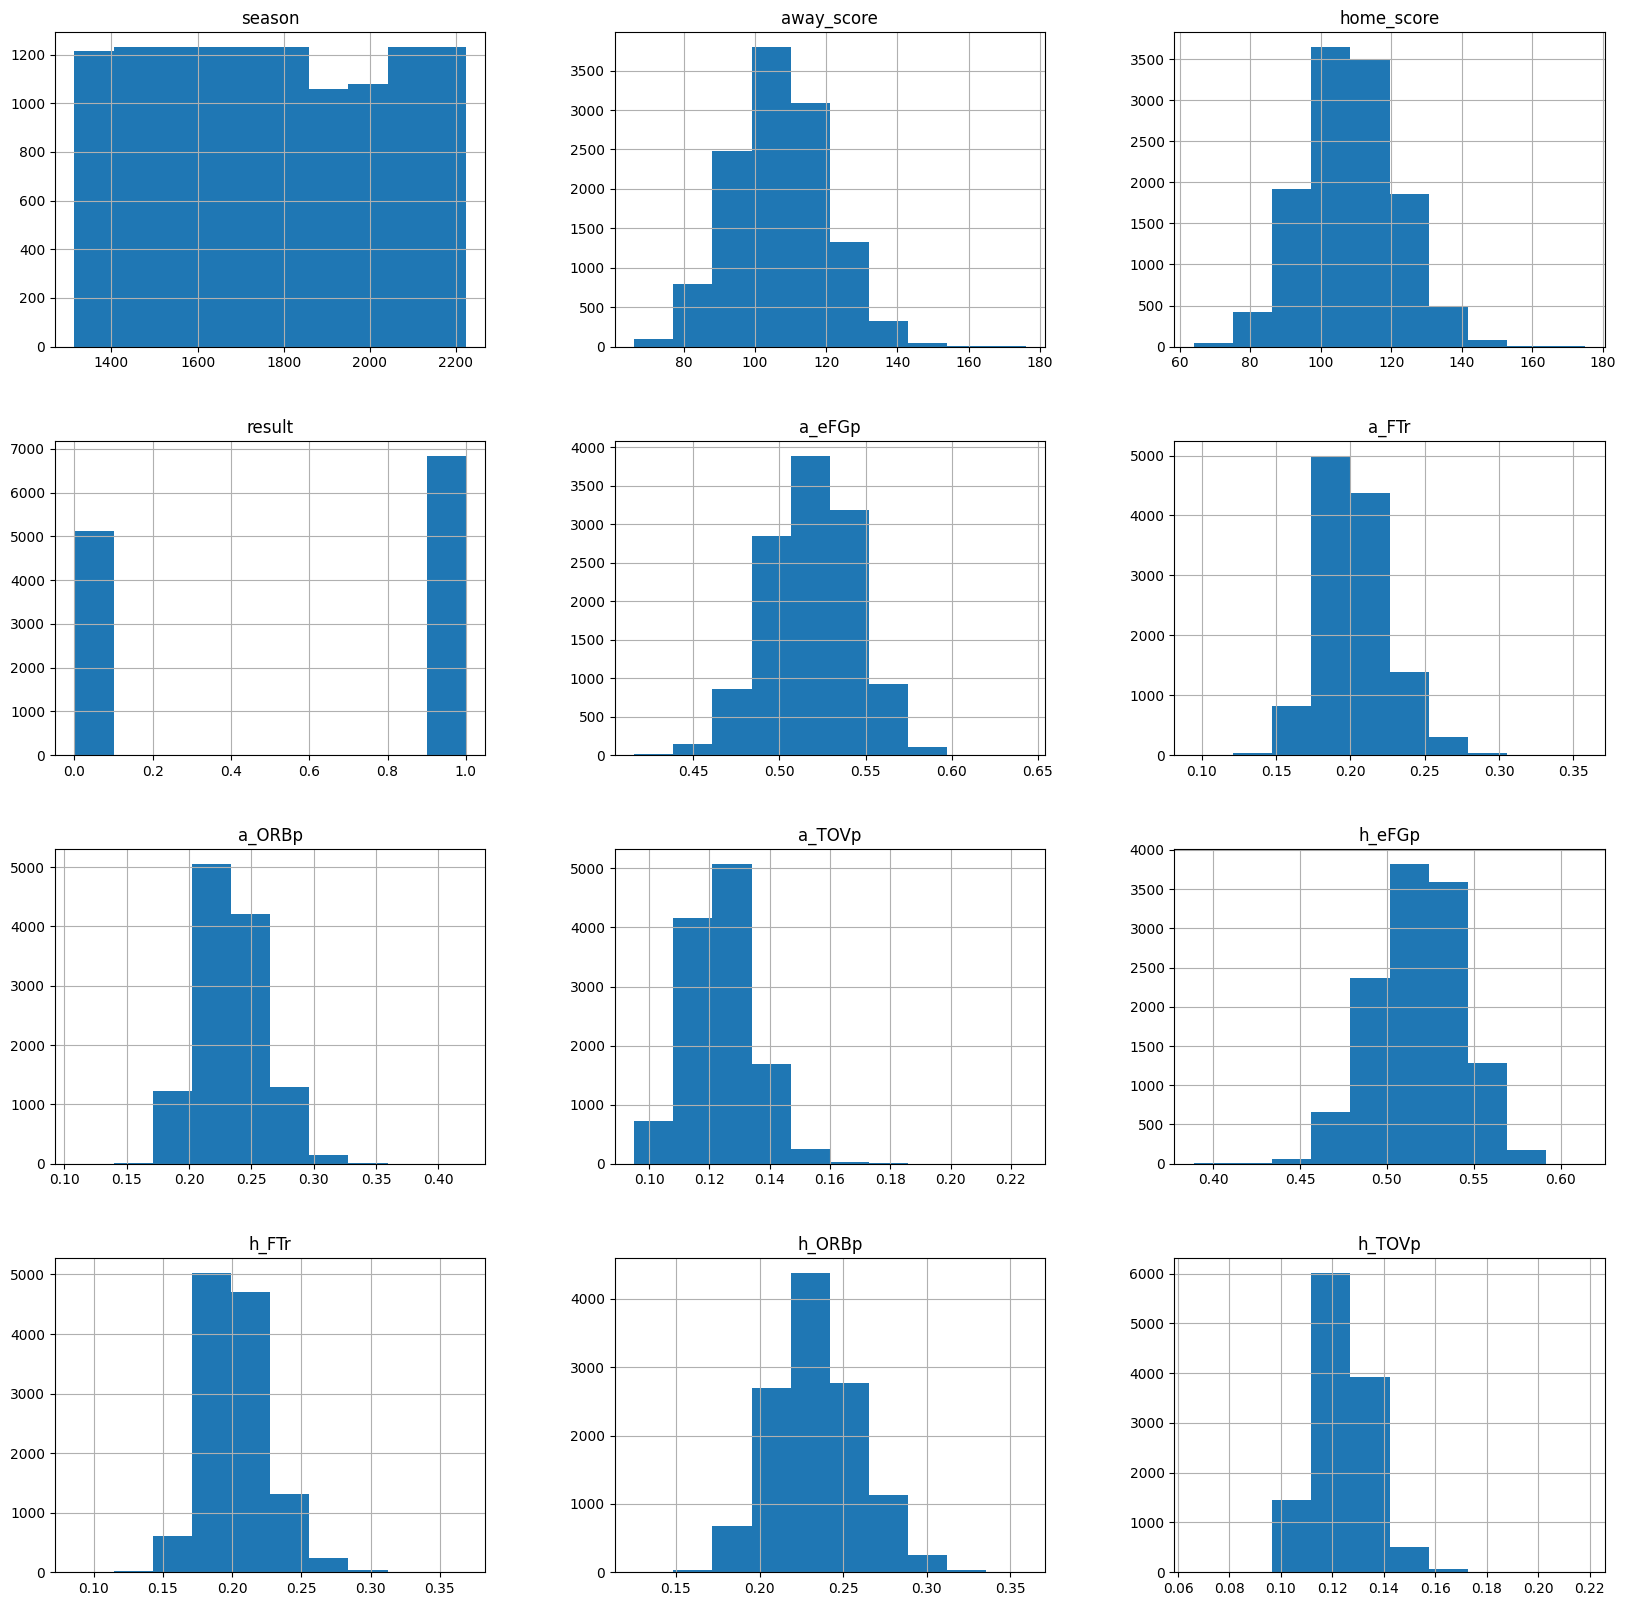

In [8]:
team_factor_50.dropna(inplace=True)
team_factor_50.reset_index(drop=True, inplace=True)
team_factor_50.hist(figsize=(20,20));

In [9]:
# create results and residuals df to hold modeling results
results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df = pd.DataFrame(columns=['y_true'])
residuals_df['y_true'] = team_factor_10['result']

In [10]:
class ModelEval():
    '''
    A pipeline to process data, perform cross validation and grid search,
    fit model, calculate model predictions and accuracy, create confidence matrix,
    and log results.

    Parameters
    ----------
    model : an instantiated scikit-learn model object.

    model_name : a string with the model name

    results_df : dataframe to hold the results for each successive model

    residuals_df : dataframe to hold the predictions for each successive model

    stats : X_train, X_test, y_train, y_test from sklearn.model_selection.train_test_split

    param_grid : the parameter grid used in the model grid search

    scaler : a 'yes'/'no' string indicating whether the model requires
             scaling the data with sklearn.preprocessing.StandardScaler

    pca : a 'yes'/'no' string indicating whether or not to perform scaling and PCA on the data.
    '''

    def __init__(self, model, model_name, results_df, residuals_df, stats, param_grid, scaler='no', pca='no', n_components=None):

        self.model = model
        self.model_name = model_name
        self.results_df = results_df
        self.residuals_df = residuals_df
        self.X_train, self.X_test, self.y_train, self.y_test = stats
        self.param_grid = param_grid
        self.cv_score = None
        self.gs_score = None

        if scaler == 'yes':
            scaler = StandardScaler()
            self.X_train = scaler.fit_transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)

        if pca == 'yes':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(self.X_train)
            X_test_scaled = scaler.transform(self.X_test)

            pca = PCA(n_components=n_components)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)

            self.X_train = X_train_pca
            self.X_test = X_test_pca

            self.explained_variance = sum(pca.explained_variance_ratio_)

    def calc_cv(self):

        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, cv=3)
        self.cv_score = cv_scores.mean()
        self.fitted_model = self.model.fit(self.X_train, self.y_train)

    def calc_grid_search(self):

        grid_search = GridSearchCV(self.model, self.param_grid, cv=3)
        self.fitted_model = grid_search.fit(self.X_train, self.y_train)
        self.params_model = grid_search.best_estimator_
        self.gs_score = grid_search.best_score_

    def calc_train_preds(self):

        self.train_preds = self.fitted_model.predict(self.X_train)

    def calc_test_preds(self):

        self.test_preds = self.fitted_model.predict(self.X_test)

    def calc_train_score(self):

        self.train_score = self.fitted_model.score(self.X_train, self.y_train)

    def calc_test_score(self):

        self.test_score = self.fitted_model.score(self.X_test, self.y_test)

    def create_conf_matrix(self):
        conf_matrix = confusion_matrix(y_true=self.y_test, y_pred=self.test_preds)
        self.disp = ConfusionMatrixDisplay(conf_matrix)
        return self.disp.plot();

    def record_results(self):

        idx = self.results_df.shape[0]
        results_df.loc[idx] = [self.model_name, self.cv_score, self.gs_score, self.train_score, self.test_score]

    def calc_residuals(self):

        train_preds_df = pd.DataFrame(self.train_preds,
                                      index=self.y_train.index)
        test_preds_df = pd.DataFrame(self.test_preds, index=self.y_test.index)

        self.model_preds = pd.concat([train_preds_df, test_preds_df]).sort_index()

        self.residuals_df[f'{self.model_name}' + '_residuals'] = self.residuals_df['y_true'] - self.model_preds[0]

    def full_diag(self):

        if self.param_grid == None:
            self.calc_cv()
        else:
            self.calc_grid_search()

        self.calc_train_preds()
        self.calc_test_preds()
        self.calc_train_score()
        self.calc_test_score()
        self.create_conf_matrix()
        self.record_results()
        self.calc_residuals()

In [11]:
team_factor_10['eFGp'] = team_factor_10['a_eFGp'] - team_factor_10['h_eFGp']
team_factor_10['FTr'] = team_factor_10['a_FTr'] - team_factor_10['h_FTr']
team_factor_10['ORBp'] = team_factor_10['a_ORBp'] - team_factor_10['h_ORBp']
team_factor_10['TOVp'] = team_factor_10['a_TOVp'] - team_factor_10['h_TOVp']

stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp']

X = team_factor_10[stat_columns]
y = team_factor_10['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799


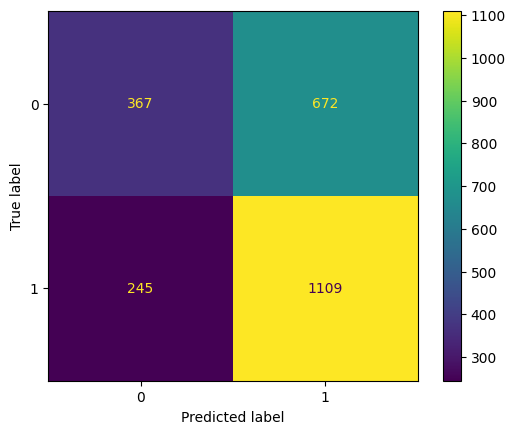

In [12]:
#Ride Regression that
ridgereg = RidgeClassifier(solver='cholesky')
ridgereg_model = ModelEval(ridgereg, 'ridge_4F_10', results_df, residuals_df, stats, None)
ridgereg_model.full_diag()

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188


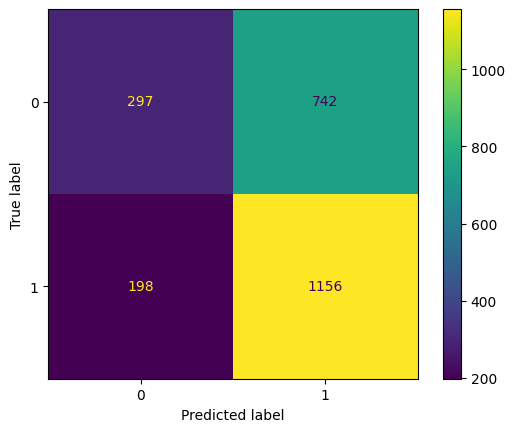

In [13]:
logreg = LogisticRegression(solver = 'newton-cg')
logreg_model = ModelEval(logreg, 'log_4F_10', results_df, residuals_df, stats, None)
logreg_model.full_diag()

results_df

In [14]:
team_factor_20['eFGp'] = team_factor_20['a_eFGp'] - team_factor_20['h_eFGp']
team_factor_20['FTr'] = team_factor_20['a_FTr'] - team_factor_20['h_FTr']
team_factor_20['ORBp'] = team_factor_20['a_ORBp'] - team_factor_20['h_ORBp']
team_factor_20['TOVp'] = team_factor_20['a_TOVp'] - team_factor_20['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_20 = pd.DataFrame(columns=['y_true'])
residuals_df_20['y_true'] = game_info['result']

stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp']


In [15]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_20[stat_columns]
y = team_factor_20['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635


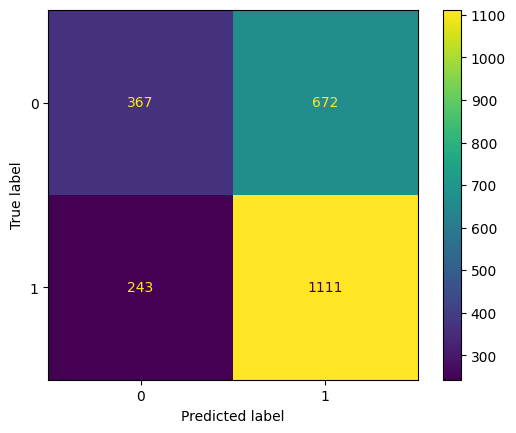

In [16]:
#Ride Regression that
ridgereg = RidgeClassifier(solver='cholesky')
ridgereg_model = ModelEval(ridgereg, 'ridge_4F_20', results_df, residuals_df_20, stats, None)
ridgereg_model.full_diag()

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949


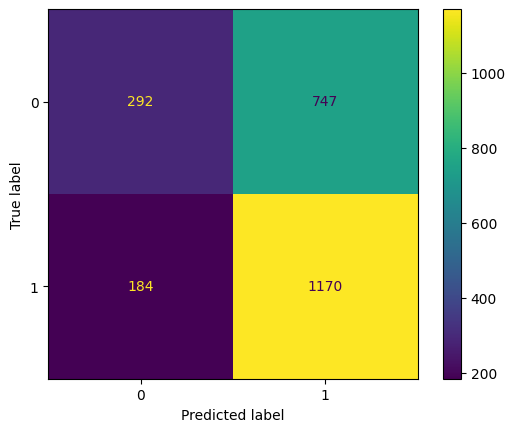

In [17]:
logreg = LogisticRegression(solver='newton-cg')

logreg_model = ModelEval(logreg, 'log_4F_20', results_df, residuals_df_20, stats, None)
logreg_model.full_diag()

results_df

In [18]:
team_factor_30['eFGp'] = team_factor_30['a_eFGp'] - team_factor_30['h_eFGp']
team_factor_30['FTr'] = team_factor_30['a_FTr'] - team_factor_30['h_FTr']
team_factor_30['ORBp'] = team_factor_30['a_ORBp'] - team_factor_30['h_ORBp']
team_factor_30['TOVp'] = team_factor_30['a_TOVp'] - team_factor_30['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_30 = pd.DataFrame(columns=['y_true'])
residuals_df_30['y_true'] = game_info['result']

In [19]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_30[stat_columns]
y = team_factor_30['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949
4,ridge_4F_30,0.629493,None,0.629808,0.622232


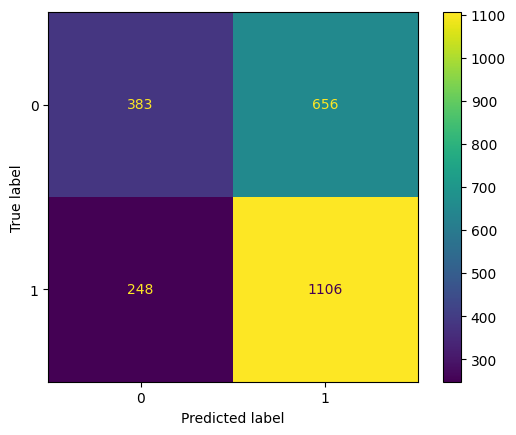

In [20]:
ridgereg = RidgeClassifier(solver='cholesky')
ridgereg_model = ModelEval(ridgereg, 'ridge_4F_30', results_df, residuals_df_30, stats, None)
ridgereg_model.full_diag()

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949
4,ridge_4F_30,0.629493,None,0.629808,0.622232
5,log_4F_30,0.616638,None,0.621969,0.614292


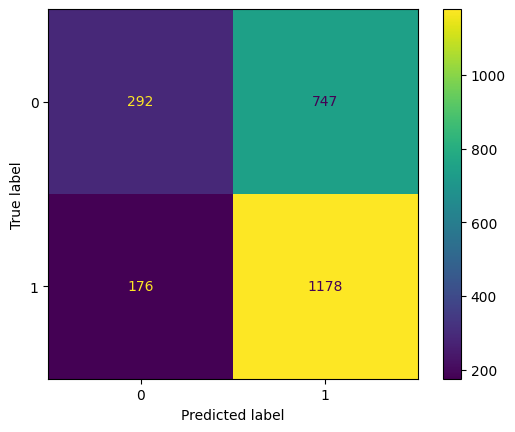

In [21]:
logreg = LogisticRegression(solver='newton-cg')

logreg_model = ModelEval(logreg, 'log_4F_30', results_df, residuals_df_30, stats, None)
logreg_model.full_diag()

results_df

In [22]:
team_factor_40['eFGp'] = team_factor_40['a_eFGp'] - team_factor_40['h_eFGp']
team_factor_40['FTr'] = team_factor_40['a_FTr'] - team_factor_40['h_FTr']
team_factor_40['ORBp'] = team_factor_40['a_ORBp'] - team_factor_40['h_ORBp']
team_factor_40['TOVp'] = team_factor_40['a_TOVp'] - team_factor_40['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_40 = pd.DataFrame(columns=['y_true'])
residuals_df_40['y_true'] = game_info['result']

In [23]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_40[stat_columns]
y = team_factor_40['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949
4,ridge_4F_30,0.629493,None,0.629808,0.622232
5,log_4F_30,0.616638,None,0.621969,0.614292
6,ridge_4F_40,0.634405,None,0.636079,0.620142


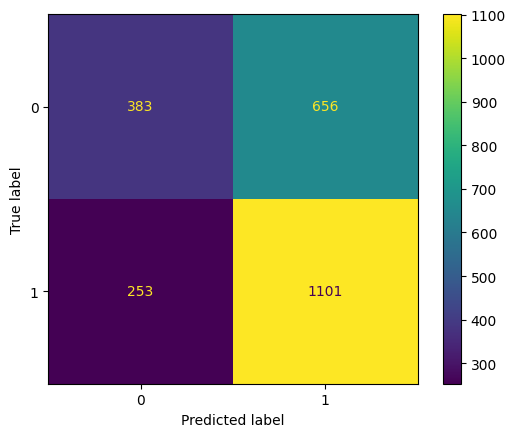

In [24]:
ridgereg = RidgeClassifier(solver='cholesky')
ridgereg_model = ModelEval(ridgereg, 'ridge_4F_40', results_df, residuals_df_40, stats, None)
ridgereg_model.full_diag()

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949
4,ridge_4F_30,0.629493,None,0.629808,0.622232
5,log_4F_30,0.616638,None,0.621969,0.614292
6,ridge_4F_40,0.634405,None,0.636079,0.620142
7,log_4F_40,0.617161,None,0.624582,0.616381


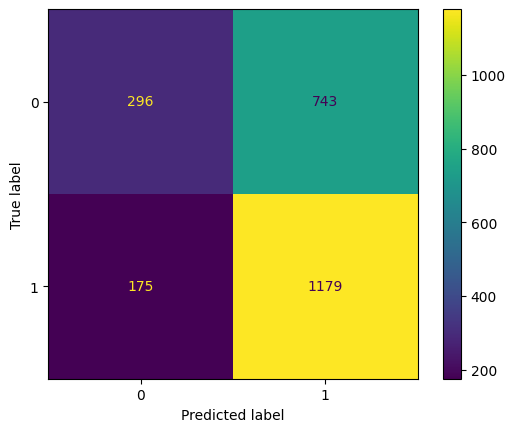

In [25]:
logreg = LogisticRegression(solver='newton-cg')

logreg_model = ModelEval(logreg, 'log_4F_40', results_df, residuals_df_40, stats, None)
logreg_model.full_diag()

results_df

In [26]:
team_factor_50['eFGp'] = team_factor_50['a_eFGp'] - team_factor_50['h_eFGp']
team_factor_50['FTr'] = team_factor_50['a_FTr'] - team_factor_50['h_FTr']
team_factor_50['ORBp'] = team_factor_50['a_ORBp'] - team_factor_50['h_ORBp']
team_factor_50['TOVp'] = team_factor_50['a_TOVp'] - team_factor_50['h_TOVp']

# results_df = pd.DataFrame(columns=['model_name', 'cv_score', 'gs_score', 'train_score', 'test_score'])
residuals_df_50 = pd.DataFrame(columns=['y_true'])
residuals_df_50['y_true'] = game_info['result']

In [27]:
stat_columns = ['eFGp', 'FTr', 'ORBp', 'TOVp', 'season']

X = team_factor_50[stat_columns]
y = team_factor_50['result']

stats = train_test_split(X, y, train_size=.80, random_state=seed)

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949
4,ridge_4F_30,0.629493,None,0.629808,0.622232
5,log_4F_30,0.616638,None,0.621969,0.614292
6,ridge_4F_40,0.634405,None,0.636079,0.620142
7,log_4F_40,0.617161,None,0.624582,0.616381
8,ridge_4F_50,0.630016,None,0.633048,0.618888


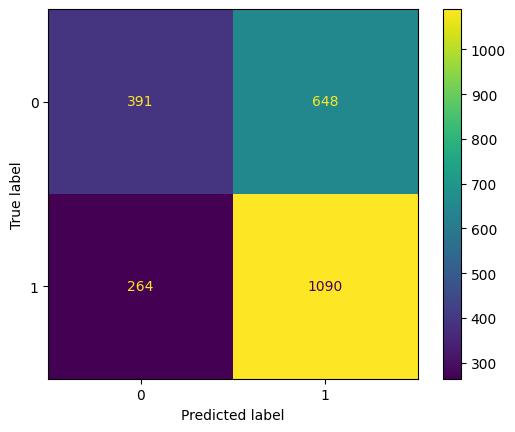

In [28]:
ridgereg = RidgeClassifier(solver='cholesky')
ridgereg_model = ModelEval(ridgereg, 'ridge_4F_50', results_df, residuals_df_50, stats, None)
ridgereg_model.full_diag()

results_df

,model_name,cv_score,gs_score,train_score,test_score
0,ridge_4F_10,0.615907,None,0.619879,0.616799
1,log_4F_10,0.611100,None,0.615907,0.607188
2,ridge_4F_20,0.627298,None,0.630121,0.617635
3,log_4F_20,0.616430,None,0.622805,0.610949
4,ridge_4F_30,0.629493,None,0.629808,0.622232
5,log_4F_30,0.616638,None,0.621969,0.614292
6,ridge_4F_40,0.634405,None,0.636079,0.620142
7,log_4F_40,0.617161,None,0.624582,0.616381
8,ridge_4F_50,0.630016,None,0.633048,0.618888
9,log_4F_50,0.619669,None,0.627090,0.613874


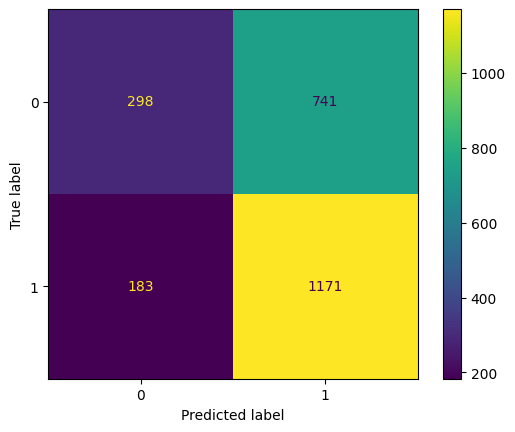

In [29]:
logreg = LogisticRegression(solver='newton-cg')

logreg_model = ModelEval(logreg, 'log_4F_50', results_df, residuals_df_50, stats, None)
logreg_model.full_diag()

results_df